# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6559/6559), 116.26 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [ ]:
class GroceryStoreDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## **Data Preprocessing**

The transformations for preprocessing training and testing data uses torchvision library in PyTorch. These transformations also act as **data augmentation for training data** by using various operations:

*   T.Tensor() converts the input image into PyTorch tensors with the pixel ranges[0, 255] to [0.0, 1.0]
*   T.Resize((340,340)) ensures all images have the same dimensions which is 340 x 340
*   T.RandomHorizontalFlip() serves as a data augmentation technique to make the model invariant to horizontal flipping, thus improving its generalization
*   T.RandomRotation(5) rotates the input images by up to 5 degrees to add some variabilities to the training data
*   T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) normalizes the input images using the specified mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5) for each channel (R, G, B) which can accelerate the training process and improve convergence.

The purpose of Data Augmentation here is to increase the data diversity and improve the model generalization. Model generalization here means it can learn to generalize better to unseen data.

While **for testing data** only includes resizing and normalization. No data augmentation is applied to the test set to ensure that the evaluation metrics reflect the model's performance on unaltered data.






In [ ]:
from torchvision import transforms as T
from torchvision.transforms import ToTensor

train_tsfms = T.Compose([
    T.ToTensor(),
    T.Resize((340,340)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(5),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_tsfms = T.Compose([
    T.ToTensor(),
    T.Resize((340,340)),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = GroceryStoreDataset(split="train", transform = train_tsfms)
test_dataset = GroceryStoreDataset(split="test", transform = test_tsfms)
val_dataset = GroceryStoreDataset(split="val", transform = test_tsfms)

# **DataLoaders**

We cannot feed the entire dataset into our model for training at once due to the fixed size of our memory, and the likelihood that the training data will exceed the memory capacity of the CPU or GPU. To manage this, we divide the dataset into smaller batches and train the model on these batches sequentially rather than all at once. The batch size is chosen based on the available memory, and it is commonly set to a power of 2.

The batch size 16 was chosen due to the limited GPU available as well as to introduces more noise into the training process, acting as a regularizer. Regularizers are techniques used to prevent overfitting by adding constraints to the model. Thus, helping model to avoid overfitting on the training data and enhances its ability to generalize better to unseen data.

In [ ]:
from torch.utils.data import random_split, DataLoader

batch_size = 16

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

In [ ]:
class_labels = set()

for _, label in train_dataset:
    class_labels.add(label)

print("Class labels:", sorted(class_labels))

Class labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


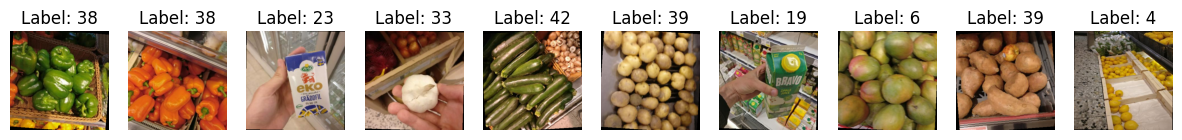

In [ ]:
import matplotlib.pyplot as plt
import random

def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    indices = random.sample(range(len(dataset)), num_images)
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)
        image = image * 0.5 + 0.5 #reversing the normalization done on transformation for visualization

        ax.imshow(image)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

show_images(train_dataset)

## **First Model**

We begin with the architecture which able to obtain the validation accuracy around 60%.

The architecture of the model is described in detail below:

**1. Convolutional Layers:**

The network begins with a series of convolutional layers designed to extract features from the input images.

**Conv1:** The first layer applies 64 filters of size 3x3 with padding of 1 to the input images, producing 64 feature maps. ReLU activation is used to introduce non-linearity.
The input shape is (16, 3, 340, 340). 16 is the batch size, 3 means the number of color channels in the input images corresponding to RGB images, 340 is the both the height and width of the images in pixels.

The output shape is calculated through this formula:
Output height = ((input height - kernel height + 2 x padding) / stride) + 1
Output height = ((340 - 3 + 2 x 1)/1) + 1 = 340

Output width = ((input width - kernel width + 2 x padding) / stride) + 1
Output width = ((340 - 3 + 2 x 1)/1) + 1 = 340

Therefore, the output shape is (batch_size, 64, 340, 340). This is also the reason we chose the pading = 1, to maintain the spatial dimension.

**Pooling**
For a MaxPooling layer with a 2x2 window and stride of 2, the operation works as follows:

- Window Size: The 2x2 window means that the pooling operation considers a 2x2 region of the input feature map at a time.
- Stride: A stride of 2 means that the window moves 2 pixels at a time. This effectively skips over every other pixel in both the height and width directions. MaxPooling operation selects the maximum value within the window, capturing the most prominent feature while discarding less relevant information.

Stride of 2 means that we reduce the spatial dimension by half, allowing to decrease the computational complexity.

The output of pooling layer can be calculated with the formula:
output height = (input height / kernel height) = (340/2) = 170
output width = (input width / kernel width) = (340/2) = 170

Therefore, the output is (16, 64, 170,170)

**Conv2:** The second convolutional layer increases the depth of the feature maps to 128, using the same filter size and padding.

Since the output of the previous layer's height and width is 170 and 170, the input for this layer is 170 both for height and width, respectfully.

The output of this layer would be:
output height = ((170 - 3 + 2 x 1)/1) + 1 = 170
output width = ((170 - 3 + 2 x 1)/1) + 1 = 170
=> (16, 128, 170, 170)

**Pooling**
the output of this layer would be:
output height = (170/2) = 85
output width = (170/2) = 85
==> (16, 128, 85, 85)

**Conv3:** The third layer further increases the depth to 256 filters.

The output of this layer would be:
output height = ((85 - 3 + 2 x 1)/1) + 1 = 85
output width = ((85 - 3 + 2 x 1)/1) + 1 = 85
=> (16, 256, 85, 85)

**Pooling**
the output of this layer would be:
output height = (85/2) = ~42
output width = (85/2) = ~42
==> (16, 256, 42, 42)

**Conv4:** The fourth convolutional layer increases the depth to 512 filters.

The output of this layer would be:
output height = ((42 - 3 + 2 x 1)/1) + 1 = 42
output width = ((42 - 3 + 2 x 1)/1) + 1 = 42
=> (16, 512, 42, 42)

**Pooling**
the output of this layer would be:
output height = (42/2) = 21
output width = (42/2) = 21
==> (16, 512, 21, 21)

**Conv5:** Another convolutional layer with 512 filters, maintaining the same depth.

The output of this layer would be:
output height = ((21 - 3 + 2 x 1)/1) + 1 = 21
output width = ((21 - 3 + 2 x 1)/1) + 1 = 21
=> (16, 512, 21, 21)

**Pooling**
the output of this layer would be:
output height = (21/2) =10
output width = (21/2) = 10
==> (16, 512, 10, 10)

**Conv6:** The final convolutional layer in this sequence also has 512 filters, maintaining the network's depth.
Pooling Layers:

The output of this layer would be:
output height = ((10 - 3 + 2 x 1)/1) + 1 =10
output width = ((10 - 3 + 2 x 1)/1) + 1 = 10
=> (16, 512, 10, 10)


**2. Dropout Layer:**

A Dropout layer with a rate of 0.4 is included after the global average pooling layer. Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to zero during training, which helps in improving the generalization of the model.

**3. Global Average Pooling:**

A Global Average Pooling (GAP) layer is applied after the final convolutional layer, reducing each feature map to a single value by averaging, resulting in a 1x1 spatial dimension. This significantly decreases the number of parameters and helps prevent overfitting.

**4. Final Convolutional Layer:**

The output of the GAP layer is passed through a final convolutional layer (Conv7) with a filter size of 1x1, which maps the 512 feature maps to the number of classes (43). This layer outputs a tensor of shape (batch_size, num_classes, 1, 1).

**5. Flattening:**

The output tensor is then flattened to a shape of (batch_size, num_classes) using the view function. This prepares the output for classification by converting the spatial dimensions into a single vector for each image in the batch.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=43):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.4)

        # global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # final Conv layer to map to num_classes
        self.conv7 = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #output shape: (batch_size, 64, 340, 340)
        x = self.pool(x) #output shape: (batch_size, 64, 170, 170)
        x = F.relu(self.conv2(x)) #output shape: (batch_size, 128, 170, 170)
        x = self.pool(x) #output shape (batch_size, 128, 85, 85)
        x = F.relu(self.conv3(x)) #output shape: (batch_size, 256, 85, 85)
        x = self.pool(x) #output shape: (batch_size, 256, 42, 42)
        x = F.relu(self.conv4(x)) #output shape: (batch_size, 512, 42, 42)
        x = self.pool(x) #output shape: (batch_size, 512, 21, 21)
        x = F.relu(self.conv5(x)) #output shape: (batch_size, 512, 21, 21)
        x = self.pool(x) #output shape: (batch_size, 512, 10, 10)
        x = F.relu(self.conv6(x)) #output shape: (batch_size, 512, 10, 10)
        x = self.global_avg_pool(x)  # apply global average pooling, output shape: (batch_size, 512, 1, 1)
        x = self.dropout(x)  # apply dropout
        x = self.conv7(x)  # final conv layer to get num_classes channels, output shape: (batch_size, 43, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, num_classes) -> (16, 43)
        return x

model = CNN(num_classes=43) #since we have 43 class labels, then the num_classes is 43
print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.4, inplace=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (conv7): Conv2d(512, 43, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'we are using {device} device')

we are using cuda device


- nn.CrossEntropyLoss() is the chosen loss function for training the model. It combines nn.LogSoftmax() and nn.NLLLoss() in one single class. This criterion is commonly used for classification tasks where the model predicts class probabilities for each class and the target is represented as an integer specifying the class label.

- torch.optim.Adam() is an optimization algorithm used to update the weights of the neural network during training.

- weight_decay=1e-4 is a regularization term that penalizes large weights to prevent overfitting. It effectively reduces the magnitude of the weights after each update, encouraging the model to be simpler and generalize better to unseen data.


In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,  weight_decay=1e-4)

The epoch set here is 100, as a limit which later we also set the early stopping where the training stops when the certain target is met. First, it initializes the model, loss function (CrossEntropyLoss), and optimizer (Adam) while monitoring training and validation metrics. During each epoch, the model undergoes training on a training dataset (train_dl), computing losses and updating weights based on backpropagation. Simultaneously, it evaluates performance on a validation dataset (val_dl) to track validation loss and accuracy. The process aims to optimize the network parameters to minimize loss and improve accuracy. The training loop includes an early stopping condition based on a target validation accuracy (target_val_accuracy) to halt training once the desired performance threshold is met. Here, we set the target is 60%. Finally, it visualizes the training and validation curves for loss and accuracy trends over epochs, providing insights into the model's learning dynamics and performance stability.

Epoch [1/100], Training Loss: 3.4722, Training Accuracy: 0.1072, Validation Loss: 3.2895, Validation Accuracy: 0.1216
Epoch [2/100], Training Loss: 3.0676, Training Accuracy: 0.1617, Validation Loss: 3.0678, Validation Accuracy: 0.1791
Epoch [3/100], Training Loss: 2.7337, Training Accuracy: 0.2102, Validation Loss: 2.7522, Validation Accuracy: 0.2365
Epoch [4/100], Training Loss: 2.4318, Training Accuracy: 0.2845, Validation Loss: 2.5871, Validation Accuracy: 0.3108
Epoch [5/100], Training Loss: 2.1980, Training Accuracy: 0.3333, Validation Loss: 2.3616, Validation Accuracy: 0.3412
Epoch [6/100], Training Loss: 1.9587, Training Accuracy: 0.3871, Validation Loss: 2.1567, Validation Accuracy: 0.3716
Epoch [7/100], Training Loss: 1.7960, Training Accuracy: 0.4235, Validation Loss: 2.0653, Validation Accuracy: 0.3514
Epoch [8/100], Training Loss: 1.6421, Training Accuracy: 0.4655, Validation Loss: 2.2749, Validation Accuracy: 0.3108
Epoch [9/100], Training Loss: 1.5780, Training Accuracy:

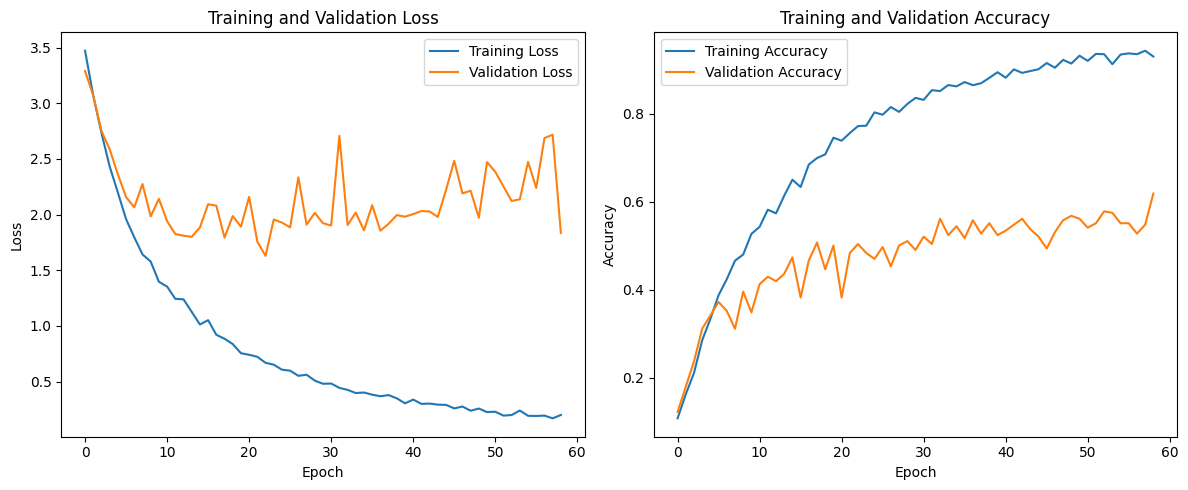

In [ ]:

num_epochs = 100

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Target validation accuracy
target_val_accuracy = 0.60

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dl)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_dl)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Check if the validation accuracy has reached the target
    if val_accuracy >= target_val_accuracy:
        print(f'Target validation accuracy of {target_val_accuracy*100}% reached at epoch {epoch+1}')
        break

# Plotting the curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


The training and validation results of the CNN model over 59 epochs show a steady decrease in training loss from 3.4722 to 0.2001, indicating effective learning. However, the validation loss decreases initially from 3.2895 to 1.7935 but then fluctuates, even increasing at times, suggesting overfitting where the model learns the training data well but struggles with new, unseen data. Despite these fluctuations, the validation accuracy improves from 12.16% to 61.82%, surpassing the target accuracy of 60.0% by epoch 59, indicating the model's capability to accurately classify unseen data. The training accuracy increases from 10.72% to 92.95%, showing significant learning. The gap between training and validation accuracy indicates that the model may still have some issues with generalization, but it converges effectively, demonstrating substantial improvement on the classification task.

In [ ]:
torch.save(model.state_dict(), 'saved_model_GAP_best.pth')
torch.save(optimizer.state_dict(), 'saved_optimizer_GAP_best.pth')

## **Second Model: Simpler CNN Architecture**

SimplerCNN reduces the number of filters in its convolutional layers compared to CNN: it starts with 32 filters and gradually increases to 256. It uses global average pooling to reduce spatial dimensions to 1x1 before the final convolutional layer maps directly to the number of classes (43).

In term of layer number, we also reduced the convolutional layers into 5 convolutional layers.Followed by global average pooling and a final convolutional layer (conv5), resulting in a total of 7 layers including pooling and dropout layers.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

num_classes = 43

class SimplerCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(SimplerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Reduced filters from 64 to 32
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Reduced filters from 128 to 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Reduced filters from 256 to 128
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Reduced filters from 512 to 256

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.4)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final Conv layer to map to num_classes
        self.conv5 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Output shape: (batch_size, 32, 340, 340)
        x = self.pool(x)  # Output shape: (batch_size, 32, 170, 170)
        x = F.relu(self.conv2(x))  # Output shape: (batch_size, 64, 170, 170)
        x = self.pool(x)  # Output shape: (batch_size, 64, 85, 85)
        x = F.relu(self.conv3(x))  # Output shape: (batch_size, 128, 85, 85)
        x = self.pool(x)  # Output shape: (batch_size, 128, 42, 42)
        x = F.relu(self.conv4(x))  # Output shape: (batch_size, 256, 42, 42)
        x = self.global_avg_pool(x)  # Output shape: (batch_size, 256, 1, 1)
        x = self.dropout(x)  # Output shape: (batch_size, 256, 1, 1)
        x = self.conv5(x)  # Output shape: (16, 43, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (16, 43)
        return x

model = SimplerCNN(num_classes=43)
print(model)



SimplerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.4, inplace=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (conv5): Conv2d(256, 43, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
model = SimplerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,  weight_decay=1e-4)

Epoch [1/63], Training Loss: 3.4956, Training Accuracy: 0.1057, Validation Loss: 3.3963, Validation Accuracy: 0.1182
Epoch [2/63], Training Loss: 3.1875, Training Accuracy: 0.1720, Validation Loss: 3.1810, Validation Accuracy: 0.1824
Epoch [3/63], Training Loss: 3.0280, Training Accuracy: 0.1928, Validation Loss: 3.0270, Validation Accuracy: 0.1892
Epoch [4/63], Training Loss: 2.8641, Training Accuracy: 0.2277, Validation Loss: 2.9234, Validation Accuracy: 0.2365
Epoch [5/63], Training Loss: 2.7120, Training Accuracy: 0.2481, Validation Loss: 2.8008, Validation Accuracy: 0.2736
Epoch [6/63], Training Loss: 2.5977, Training Accuracy: 0.2644, Validation Loss: 2.6677, Validation Accuracy: 0.2770
Epoch [7/63], Training Loss: 2.5099, Training Accuracy: 0.2833, Validation Loss: 2.5642, Validation Accuracy: 0.3041
Epoch [8/63], Training Loss: 2.4095, Training Accuracy: 0.2989, Validation Loss: 2.6565, Validation Accuracy: 0.2635
Epoch [9/63], Training Loss: 2.3287, Training Accuracy: 0.3114, 

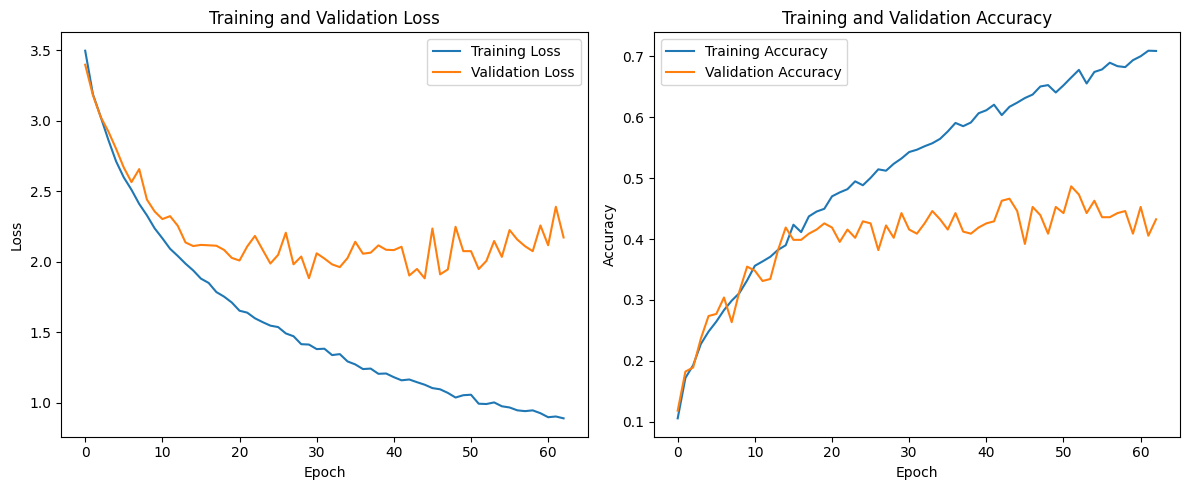

In [ ]:
num_epochs = 63  # since on previous model, the accuracy 60% is already obtained at epoch 59

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Target validation accuracy
target_val_accuracy = 0.60

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dl)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_dl)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Check if the validation accuracy has reached the target
    if val_accuracy >= target_val_accuracy:
        print(f'Target validation accuracy of {target_val_accuracy*100}% reached at epoch {epoch+1}')
        break

# Plotting the curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


The training and validation results of the simpler CNN model over 63 epochs show a significant improvement in both training and validation performance, but with limitations compared to the previous model. The training loss decreases from 3.4956 to 0.8897, and the training accuracy increases from 10.57% to 70.87%, indicating effective learning. The validation loss decreases from 3.3963 to 1.9022 initially but fluctuates and increases towards the end, reaching 2.1718, suggesting persistent overfitting where the model struggles with new data. The validation accuracy improves from 11.82% to 48.65%, which is a notable improvement but falls short of the 60.0% target achieved by the previous model. The previous model, despite its fluctuations in validation loss, reached a higher validation accuracy of 61.82% by epoch 59, demonstrating better generalization and classification capability on unseen data. The simpler model's lower complexity might contribute to less overfitting, but it also seems to limit its ability to capture the data's complexity, resulting in lower overall performance compared to the more complex model.

In [ ]:
torch.save(model.state_dict(), 'saved_model_simplerCNN.pth')
torch.save(optimizer.state_dict(), 'saved_optimizer_simplerCNN.pth')

## **Model 3: Simplest Model**


SimplestCNN consists of a straightforward architecture with only 1 convolutional layer (conv1), followed by global average pooling and a final convolutional layer (conv2). This results in a total of 3 layers, including the pooling operation.

In [ ]:
class SimplestCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(SimplestCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # one convolutional layer with 16 filters
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # global average pooling
        self.conv2 = nn.Conv2d(16, num_classes, kernel_size=1)  # final conv layer to map to num_classes

    def forward(self, x):
        x = F.relu(self.conv1(x)) # output shape: (16, 16, 340, 340)
        x = self.pool(x)  #output shape: (16, 16, 1, 1)
        x = self.conv2(x)  # Final conv layer to get num_classes channels, output shape: (16, 43, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, num_classes): (16, 43)
        return x

# Initialize the model
model = SimplestCNN(num_classes=num_classes)
print(model)

SimplestCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (conv2): Conv2d(16, 43, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
model = SimplestCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,  weight_decay=1e-4)

In [ ]:
# Set a very high number of epochs
num_epochs = 63  # since on previous model, the accuracy 60% is already obtained at epoch 59

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Target validation accuracy
target_val_accuracy = 0.60

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dl)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_dl)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Check if the validation accuracy has reached the target
    if val_accuracy >= target_val_accuracy:
        print(f'Target validation accuracy of {target_val_accuracy*100}% reached at epoch {epoch+1}')
        break

# Plotting the curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch [1/63], Training Loss: 3.7605, Training Accuracy: 0.0750, Validation Loss: 3.7373, Validation Accuracy: 0.0811
Epoch [2/63], Training Loss: 3.7290, Training Accuracy: 0.1246, Validation Loss: 3.7117, Validation Accuracy: 0.0777
Epoch [3/63], Training Loss: 3.6929, Training Accuracy: 0.1216, Validation Loss: 3.6808, Validation Accuracy: 0.0912
Epoch [4/63], Training Loss: 3.6491, Training Accuracy: 0.1042, Validation Loss: 3.6425, Validation Accuracy: 0.0946
Epoch [5/63], Training Loss: 3.5987, Training Accuracy: 0.1201, Validation Loss: 3.6002, Validation Accuracy: 0.0574
Epoch [6/63], Training Loss: 3.5466, Training Accuracy: 0.1318, Validation Loss: 3.5592, Validation Accuracy: 0.0507
Epoch [7/63], Training Loss: 3.4993, Training Accuracy: 0.1269, Validation Loss: 3.5234, Validation Accuracy: 0.0642
Epoch [8/63], Training Loss: 3.4597, Training Accuracy: 0.1155, Validation Loss: 3.4969, Validation Accuracy: 0.0676
Epoch [9/63], Training Loss: 3.4299, Training Accuracy: 0.1106, 

KeyboardInterrupt: 

The training and validation outcomes of the simplest CNN model over 30 epochs shows minimal learning and poor performance. The training loss only slightly decreases from 3.7605 to 3.1712, while training accuracy shows a modest increase from 7.50% to 18%.86%, indicating limited learning capability. Similarly, the validation loss reduces from 3.7373 to 3.2597, but validation accuracy remains low and fluctuates, only improving slightly from 8.11% to 13.18%. This simplest model struggles significantly with both training and validation data, pointing to insufficient complexity to capture essential features for effective learning and classification. In comparison to the previous, more complex models that achieved higher training and validation accuracies and demonstrated more substantial learning, this model's performance is inadequate.